## 0. Preprocessing

In [28]:
from rolling_time_series_model import RollingLinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold,f_regression
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Lasso,LassoCV,RidgeCV
from sklearn.model_selection import train_test_split
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import time
import math
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
#---------------------------------------------------------------------------------------------------------------------------
# File uploading
features=pd.read_csv(r'C:\Users\12053\Desktop\DataSpartan\first meeting\features.csv')
features.set_index('timestamp',inplace=True) # Loading the features dataset
features.index=pd.to_datetime(features.index)
candlesticks=pd.read_csv(r'C:\Users\12053\Desktop\DataSpartan\first meeting\candlesticks.csv')
candlesticks.set_index('timestamp',inplace=True)
candlesticks.index=pd.to_datetime(candlesticks.index)
#---------------------------------------------------------------------------------------------------------------------------
# Standardscale & shift，so that we use today's data to predict tomorrow's return.
standard_process=pd.DataFrame(StandardScaler().fit_transform(features),index=features.index,columns=features.columns)
df_v=candlesticks[['returns']].shift(-1) 
df_v.columns=['test']
candlesticks=pd.concat([candlesticks, df_v], axis=1)
#---------------------------------------------------------------------------------------------------------------------------
# Combination
df=standard_process.join(candlesticks)
df.dropna(how='any',inplace=True) # Delete null values
#---------------------------------------------------------------------------------------------------------------------------
# Split dependent variables and independent variable
df_with_features=df.iloc[:,:131] # X independent variable
label=df.iloc[:,-1:] # Y dependt variable
# seaborn.set()
seaborn.set()


## 1. Functions  
VIF, pvalues, feature importance, RFE

In [278]:
def rolling_by_forloop_SVR(df_with_features,label,window):
    start=time.time()
    beta=[]
    window=window
    coef=[]
    for i in range(window,len(df_with_features)+1):
        # SV Regression--------------------------------------------------------------------------
        X=df_with_features.iloc[i-window:i,:]
        Y=label[i-window:i] 
        results=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01).fit(X,Y)
      
        # get coefficient----------------------------------------------------------------------------
        coef=results.coef_[0]
        pval=f_regression(X,label[i-window:i],center=True)[1]
        beta.append(coef)
        
    # End the for-loop and get results
    df_beta=pd.DataFrame(beta,index=df_with_features.index[window-1:],columns=df_with_features.columns)
    
    for i in range(0,len(df_with_features.columns)//11+1):
        ax=df_beta.dropna().iloc[:,i*11:(i+1)*11]
        ax.plot(figsize=(15,3))
        plt.title('Parameters change over time')
        plt.legend(loc='upper left')


    describe=pd.DataFrame(df_beta.mean(),index=df_with_features.columns,columns=['mean'])
    describe['variance']=df_beta.var()
    describe['min']=df_beta.min()
    describe['max']=df_beta.max()
    
    end=time.time()
    print('Running time: '+str(end-start)+'s')
    
    return df_beta,describe

'''def OLSrolling(df_with_features,label,window,x,visualization=True):

    def rollingOLS(X,Y,window):

        results=sm.regression.rolling.RollingOLS(Y, X,window=window).fit()
        df_coef=results.params
        df_p_values=pd.DataFrame(results.pvalues,index=X.index,columns=X.columns)

        describe=pd.DataFrame(df_coef.mean(),index=X.columns,columns=['mean'])
        describe['variance']=df_coef.var()
        describe['min']=df_coef.min()
        describe['max']=df_coef.max()


        return df_coef,df_p_values,describe.T

#    temp1_coef=pd.DataFrame(index=df_with_features.index)
#    temp1_pvalues=pd.DataFrame(index=df_with_features.index)
#    temp1_describe=pd.DataFrame(index=['mean','variance','min','max'])

    def loop(df_with_features,label):
        a,b,c=rollingOLS(df_with_features,label,window)
        return a,b,c

    def visualization(x):
        for i in range(0,len(df_with_features.columns)//11+1):
            if str(x)=='p':
                ax=df_p_values[df_p_values<0.05].iloc[:,i*11:(i+1)*11]
            if str(x)=='coef':
                ax=df_coef.dropna().iloc[:,i*11:(i+1)*11]
            ax.plot(figsize=(15,3))
            plt.title('Parameters change over time')
            plt.legend(loc='upper left')
        plt.show()
#        plt.savefig(fname="pic.png",figsize=[10,10])
    
    df_coef,df_p_values,describe=loop(df_with_features,label)
    
    try:
        visualization(x)
    except TypeError as e:
        print(' ')
    
    return df_coef,df_p_values,describe'''

'def OLSrolling(df_with_features,label,window,x,visualization=True):\n\n    def rollingOLS(X,Y,window):\n\n        results=sm.regression.rolling.RollingOLS(Y, X,window=window).fit()\n        df_coef=results.params\n        df_p_values=pd.DataFrame(results.pvalues,index=X.index,columns=X.columns)\n\n        describe=pd.DataFrame(df_coef.mean(),index=X.columns,columns=[\'mean\'])\n        describe[\'variance\']=df_coef.var()\n        describe[\'min\']=df_coef.min()\n        describe[\'max\']=df_coef.max()\n\n\n        return df_coef,df_p_values,describe.T\n\n#    temp1_coef=pd.DataFrame(index=df_with_features.index)\n#    temp1_pvalues=pd.DataFrame(index=df_with_features.index)\n#    temp1_describe=pd.DataFrame(index=[\'mean\',\'variance\',\'min\',\'max\'])\n\n    def loop(df_with_features,label):\n        a,b,c=rollingOLS(df_with_features,label,window)\n        return a,b,c\n\n    def visualization(x):\n        for i in range(0,len(df_with_features.columns)//11+1):\n            if str(x

Features are selected by eliminating multicollinearity. Concept of VIF(Variance Inflation Factor) needs to be introduced.  
> https://www.statisticshowto.com/variance-inflation-factor/  
*Exactly how large a VIF has to be before it causes issues is a subject of debate. What is known is that the more your VIF increases, the less reliable your regression results are going to be. In general, a VIF above 10 indicates high correlation and is cause for concern*  

![VIF](VIF.png)

In [64]:
def variance_inflation_factor(df_with_features, index):
    
    col_num = df_with_features.shape[1] # get columns number(features number)
    x=df_with_features.as_matrix() #
    
    x_i = x[:, index] # particular feature's data
    temp = np.arange(col_num) != index
    x_noti = x[:, temp] # data without that feature

    lr = LinearRegression(fit_intercept=True) 
    lr.fit(x_noti, x_i)  # To test whether there is a multicollinearity between this feature and others
    r_squared_i=r2_score(x_i, lr.predict(x_noti)) # if R^2 is high, then the level of multicollinearity is high.

    vif = 1. / (1. - r_squared_i) # formula of variance inflation factor

    return vif

def calculate_vif(x):
    
    list_vif=[variance_inflation_factor(x, i).round(4) for i in range(len(x.columns))]    
    df_vif=pd.DataFrame(list_vif,index=x.columns, columns=['vif'])
    
    return df_vif

In [65]:
def calculate_pval(x, y):
    # Here, f_regression is used to test which period of time the feature is reliable.
    fvalues, pval=f_regression(x, y, center=True)
    df_pval=pd.DataFrame(pval.round(4), index = x.columns, columns = ['pval'])
    
    return df_pval

In [139]:
def feature_importance(df_with_features,label,window):
    start=time.time()
    feature_imp=[]
    for i in range(window,len(df_with_features)+1):
        
        X=df_with_features.iloc[i-window:i,:]
        Y=label[i-window:i] 
        results=RandomForestRegressor().fit(X,Y)
        feature_imp.append(results.feature_importances_.tolist())

    df_feature_imp=pd.DataFrame(feature_imp,index=df_with_features.index[window-1:],columns=df_with_features.columns)
    
    return df_feature_imp

In [279]:
def global_fit(x,y):
    
    lr=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01).fit(x,y)

    lr_coefficients = lr.coef_.tolist()[0]
    lr_coefficients.insert(0,float(lr.intercept_))
    
    df_coef=pd.DataFrame(lr_coefficients,index=x.columns.insert(0,'intecept'),columns=['coef'])
    df_vif=calculate_vif(x)
    df_pval=calculate_pval(x, y)

    model=RandomForestRegressor()
    model.fit(x, y)  
    df_feature_imp=pd.DataFrame(data=model.feature_importances_.round(4), index=x.columns, columns=['feature_imp'])
    df_stats_summary=df_coef.join(df_vif).join(df_pval).join(df_feature_imp)

    return df_stats_summary

The above part is the construction of the functions

## 2 Feature selection

In [280]:
df_summary=global_fit(df_with_features,label)
df_summary

,coef,vif,pval,feature_imp
intecept,0.004124,NaN,NaN,NaN
f_1,0.000118,inf,0.7049,0.0006
f_2,-0.000346,inf,0.7538,0.0005
f_3,0.001523,inf,0.7373,0.0014
f_4,-0.001453,93.6126,0.3654,0.0006
...,...,...,...,...
f_127,0.004785,354.4544,0.9835,0.0003
f_128,0.005843,87.4010,0.9284,0.0005
f_129,0.002183,inf,0.7543,0.0002
f_130,-0.006915,inf,0.8037,0.0004


Delete features that have multicollinearity (VIF>10)

In [287]:
# feature selection by VIF value
list_select_features=df_summary[df_summary['vif']<10].index.tolist()
list_select_features

# feature selection by p value
'''list_select_features=df_summary[df_summary['pval']<0.05].index.tolist()
list_select_features'''

# feature selection by feature_imp
'''list_select_features=df_summary.sort_values(by='feature_imp',ascending=False).index[:10].tolist()
list_select_features'''

['f_6', 'f_7', 'f_8', 'f_33', 'f_38', 'f_57', 'f_131']

In [289]:
global_fit(df_with_features[list_select_features],label)

,coef,vif,pval,feature_imp
intecept,0.002197,NaN,NaN,NaN
f_6,-0.057154,3.3839,0.0903,0.3464
f_7,0.000998,2.7852,0.5008,0.0291
f_8,0.000032,1.9221,0.4480,0.0242
f_33,0.000093,1.0186,0.2530,0.0083
f_38,-0.002943,1.0430,0.6346,0.0008
f_57,0.000428,1.0036,0.8111,0.0084
f_131,0.068544,2.5128,0.0000,0.5827


## 2.1 Outcome -- take VIF as an example

In [306]:
# Predict the return using all features
from sklearn.model_selection import train_test_split
import time
start=time.time()
X_train, X_test, y_train, y_test = train_test_split(df_with_features, label, test_size=0.25,random_state=42,shuffle=False)

results=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01).fit(X_train,y_train)
yhat2=results.predict(X_test)
print(r2_score(y_test,yhat2))
end=time.time()
print('Running time: '+str(round(end-start,2))+'s')



0.6686692870925763
Running time: 0.2s


In [308]:
# Predict the return using selected features
from sklearn.model_selection import train_test_split
import time
start=time.time()
X_train, X_test, y_train, y_test = train_test_split(df_with_features[list_select_features], label, test_size=0.25,random_state=42,shuffle=False)

results=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01).fit(X_train,y_train)
yhat2=results.predict(X_test)
print(r2_score(y_test,yhat2))
end=time.time()
print('Running time: '+str(round(end-start,2))+'s')

0.9873563155173972
Running time: 0.07s


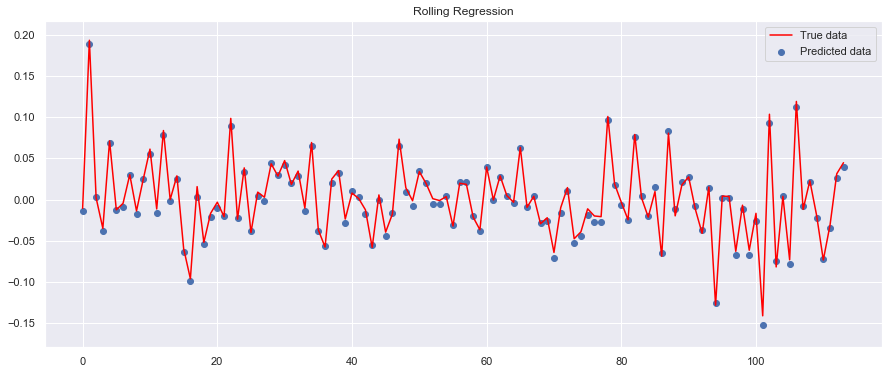

0.9916433408848025


In [309]:
# Rolling predict the return using selected features
window=int(0.85*len(df_with_features)) #642
yhat=[]
for i in range(window,len(df_with_features)):
        # SV Regression--------------------------------------------------------------------------
        X=df_with_features[list_select_features].iloc[i-window:i,:]
        Y=label[i-window:i] 
        results=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01).fit(X,Y)
        yhat.append(results.predict(df_with_features[list_select_features].iloc[i:i+1,:]))
plt.figure(figsize=(15,6))
plt.scatter(np.arange(0,len(yhat),1),yhat,marker='o',edgecolors='b',label='Predicted data')
plt.plot(np.arange(0,len(yhat),1),label.iloc[window:],c='red',label='True data')
plt.legend()
plt.title('Rolling Regression')
plt.show()
print(r2_score(label.iloc[window:],yhat))

## 2.2 Other -- feature importance

In [314]:
# feature selection by feature_imp
list_select_features=df_summary.sort_values(by='feature_imp',ascending=False).index[:10].tolist()
# Predict the return using selected features
from sklearn.model_selection import train_test_split
import time
start=time.time()
X_train, X_test, y_train, y_test = train_test_split(df_with_features[list_select_features], label, test_size=0.25,random_state=42,shuffle=False)

results=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01).fit(X_train,y_train)
yhat2=results.predict(X_test)
print(r2_score(y_test,yhat2))
end=time.time()
print('Running time: '+str(round(end-start,2))+'s')

0.9893258241563572
Running time: 0.13s


### The change of feature importance

In [197]:
# plt.figure(figsize=(15,3))
# plt.title('The change of feature importance')
# plt.plot(feature_importance(df_with_features,label,200))

x=feature_importance(df_with_features,label,200)

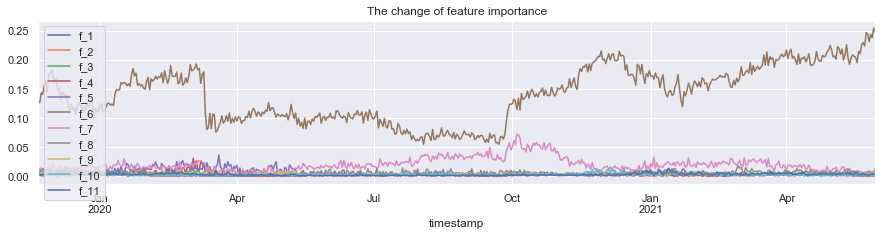

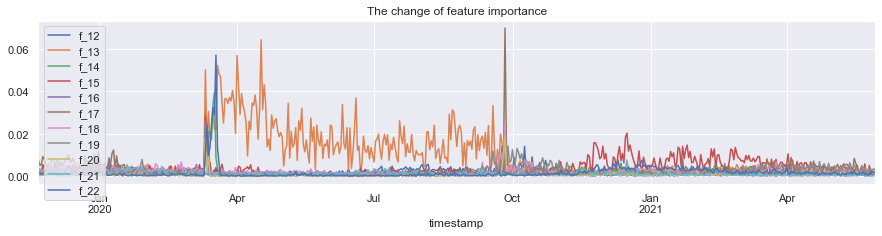

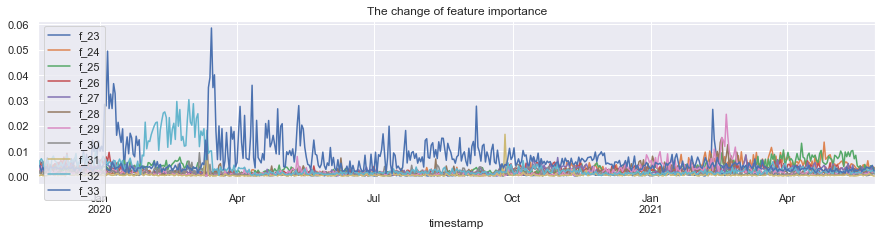

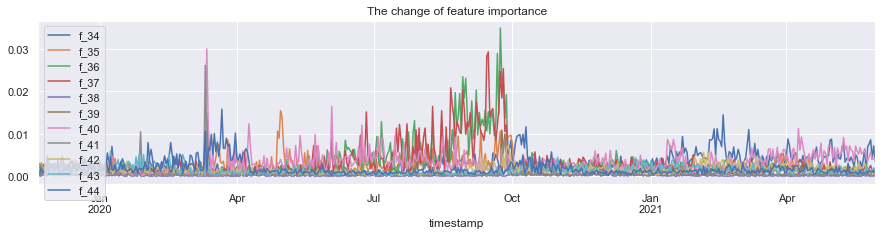

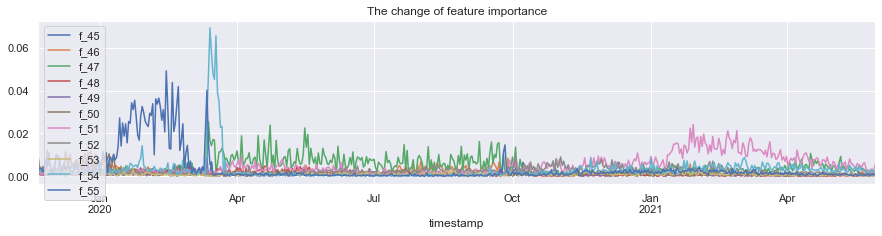

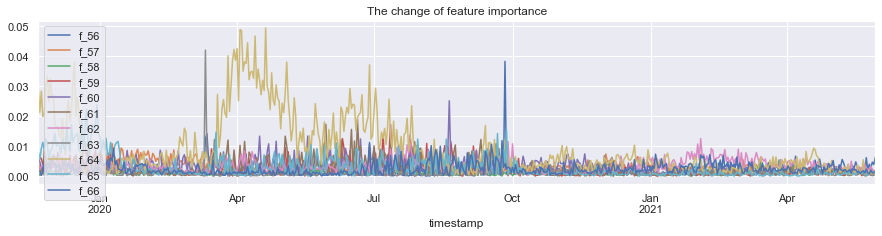

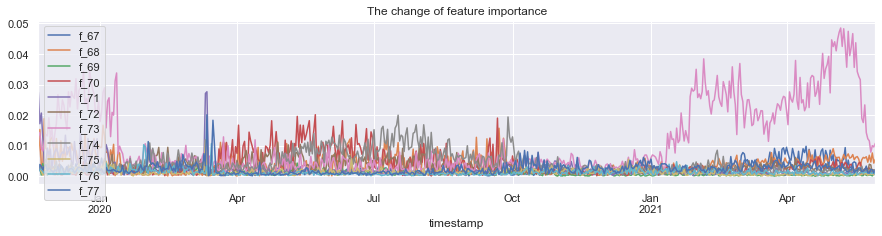

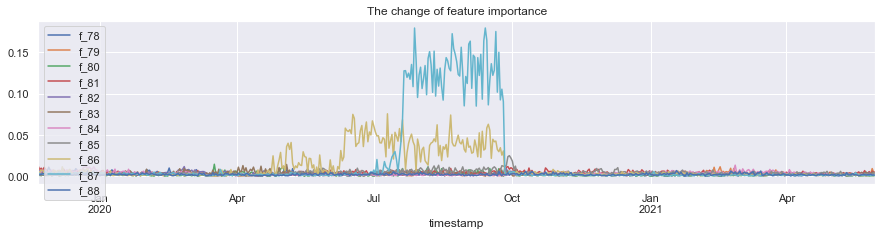

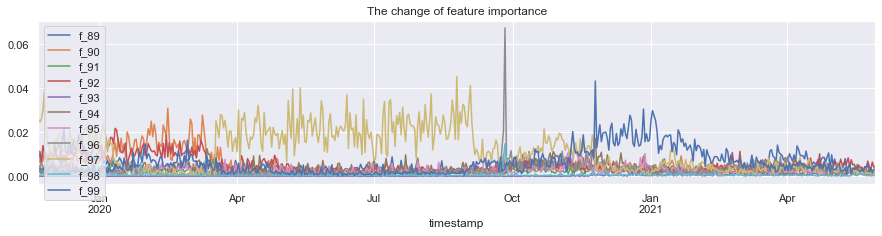

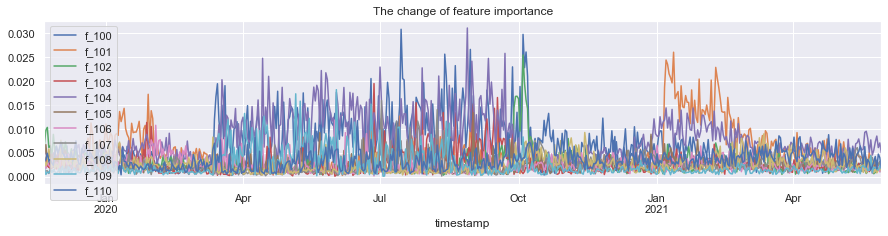

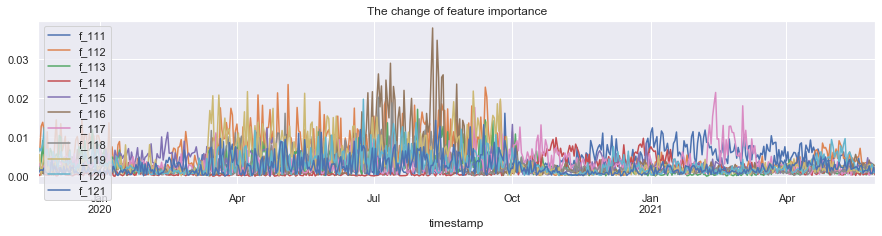

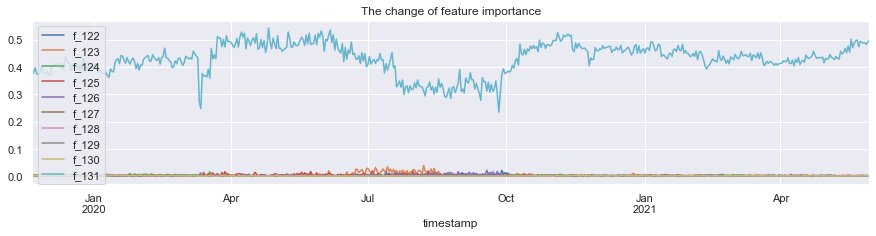

In [282]:
for i in range(0,len(x.columns)//11+1):
    ax=x.iloc[:,i*11:(i+1)*11]
    ax.plot(figsize=(15,3))
    plt.title('The change of feature importance')
    plt.legend(loc='upper left')

## 2.3 Recursive Feature Elimination

In [198]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

rfe=RFE(estimator=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01),n_features_to_select=10)   # number of feature 
 
Feature=rfe.fit_transform(df_with_features,label)
 
df_with_features.columns[rfe.get_support()] # Check the features that meet the criteria

Index(['f_6', 'f_56', 'f_68', 'f_99', 'f_105', 'f_106', 'f_107', 'f_109',
       'f_113', 'f_131'],
      dtype='object')

In [317]:
# Predict the return using all features
from sklearn.model_selection import train_test_split
import time
start=time.time()
X_train, X_test, y_train, y_test = train_test_split(df_with_features, label, test_size=0.25,random_state=42,shuffle=False)

results=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01).fit(X_train,y_train)
yhat2=results.predict(X_test)
print(r2_score(y_test,yhat2))
end=time.time()
print('Running time: '+str(round(end-start,2))+'s')



0.6686692870925763
Running time: 0.19s


In [318]:
# Predict the return using features selected by RFE
from sklearn.model_selection import train_test_split
import time
start=time.time()
X_train, X_test, y_train, y_test = train_test_split(df_with_features[features_selected_by_RFE], label, test_size=0.25,random_state=42,shuffle=False)

results=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01).fit(X_train,y_train)
yhat2=results.predict(X_test)
print(r2_score(y_test,yhat2))
end=time.time()
print('Running time: '+str(round(end-start,2))+'s')

0.9509848581802122
Running time: 0.14s


In [323]:
features_selected_by_RFE=['f_6', 'f_56', 'f_68', 'f_99', 'f_105', 'f_106', 'f_107', 'f_109','f_113', 'f_131']

window=int(0.75*len(df_with_features))
yhat=[]
for i in range(window,len(df_with_features)):
        # SV Regression--------------------------------------------------------------------------
        X=df_with_features[features_selected_by_RFE].iloc[i-window:i,:]
        Y=label[i-window:i] 
        results=SVR(kernel='linear',tol=1e-5,C=2,epsilon=0.01).fit(X,Y)
        yhat.append(results.predict(df_with_features[features_selected_by_RFE].iloc[i:i+1,:]))


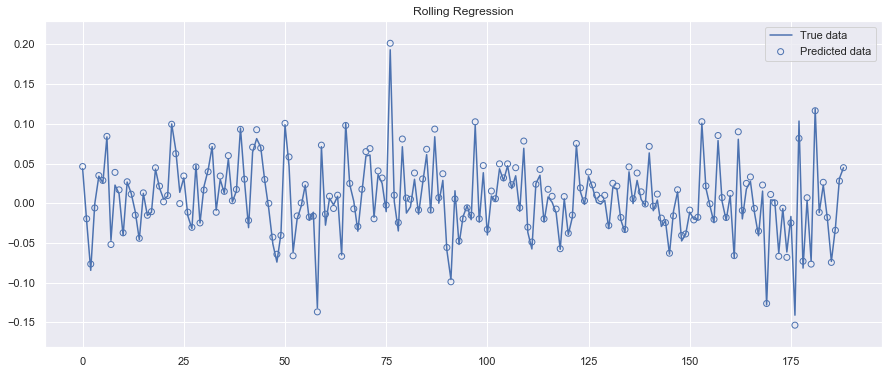

In [326]:
plt.figure(figsize=(15,6))
plt.scatter(np.arange(0,len(yhat),1),yhat,marker='o',c='',edgecolors='b',label='Predicted data')
plt.plot(np.arange(0,len(yhat),1),label.iloc[window:],label='True data')
plt.title('Rolling Regression')
plt.legend()

In [291]:
r2_score(y_test,yhat)

0.9871947862436797